In [1]:
import nltk
import pandas as pd
import math

In [2]:
import numpy as np

In [3]:
from pprint import pprint
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk import WhitespaceTokenizer
from nltk.tokenize import TweetTokenizer
from nltk.util import ngrams
from collections import Counter

In [4]:
file_name = 'el-en/europarl-v7.el-en.en'
with open(file_name, 'r', encoding='utf8') as myfile:
    corpus = myfile.read().replace('\n', ' ')

In [5]:
'''
Sentence splitting
'''
sentences = sent_tokenize(corpus)
#get first few sentences
print(sentences[0])
print("_________________")
print(sentences[1])
print("_________________")
print(sentences[2])

Resumption of the session I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.
_________________
Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful.
_________________
You have requested a debate on this subject in the course of the next few days, during this part-session.


In [6]:
#number of sentences in corpus 
length=len(sentences)
length

1307128

In [7]:
#take subsets of corpus as training, development and test set.
k=round(0.1*length)
train =sentences[:k]
develop =sentences[k:2*k]
test =sentences[2*k:3*k]

In [8]:
'''
word tokenization
'''
def word_tokenize(data_set):
    tweet_wt = TweetTokenizer()
    i = 0
    sentences_tokenized = []
    for sent in data_set:
        sent_tok = tweet_wt.tokenize(sent)
        sentences_tokenized.append(sent_tok)
        #print word tokenization for the 2 first sentences
        if i <= 1:
            print(sent_tok)
            print("_________________")
        i+=1
    return sentences_tokenized

In [9]:
#tokenize each set
train_sentences_tokenized = word_tokenize(train)
test_sentences_tokenized = word_tokenize(test)
develop_sentences_tokenized = word_tokenize(develop)

['Resumption', 'of', 'the', 'session', 'I', 'declare', 'resumed', 'the', 'session', 'of', 'the', 'European', 'Parliament', 'adjourned', 'on', 'Friday', '17', 'December', '1999', ',', 'and', 'I', 'would', 'like', 'once', 'again', 'to', 'wish', 'you', 'a', 'happy', 'new', 'year', 'in', 'the', 'hope', 'that', 'you', 'enjoyed', 'a', 'pleasant', 'festive', 'period', '.']
_________________
['Although', ',', 'as', 'you', 'will', 'have', 'seen', ',', 'the', 'dreaded', "'", 'millennium', 'bug', "'", 'failed', 'to', 'materialise', ',', 'still', 'the', 'people', 'in', 'a', 'number', 'of', 'countries', 'suffered', 'a', 'series', 'of', 'natural', 'disasters', 'that', 'truly', 'were', 'dreadful', '.']
_________________
['They', 'believe', 'that', 'this', 'will', 'offer', 'a', 'solution', 'to', 'the', 'occurrence', 'of', 'at', 'least', 'some', 'phenomena', '.']
_________________
['In', 'my', 'view', ',', 'this', 'is', 'the', 'wrong', 'approach', '.']
_________________
['You', 'only', 'have', 'to', 'c

In [10]:
#join sentences 
train = ' '.join(train)

In [11]:
'''
Counting words
'''
tweet_wt = TweetTokenizer()
tokens = tweet_wt.tokenize(train)
count = Counter(tokens)
most_common = count.most_common()

In [12]:
#get tokens that occur less than ten times
lessthanten = set()

for i in range(0,len(count)):
    if most_common[i][1] < 10:
        lessthanten.add(most_common[i][0])

In [13]:
print(len(lessthanten))
print(len(most_common))

28888
39474


In [14]:
## include in the vocabulary only words that occur at least ten times in the training set
Voc=set(tokens).difference(lessthanten)

In [15]:
## Vocabulary size
len(Voc)

10586

In [16]:
## replace all OOV words by a special token *UNK* in the sentences of the training set
train_tokenized = []
for sent in train_sentences_tokenized:
    new_sent = [w if w in Voc else '*UNK*' for w in sent]
    train_tokenized.append(new_sent)

In [17]:
#do the same for the test set
test_tokenized = []
for sent in test_sentences_tokenized:
    new_sent = [w if w in Voc else '*UNK*' for w in sent]
    test_tokenized.append(new_sent)

In [18]:
#do the same for the development set
develop_tokenized = []
for sent in develop_sentences_tokenized:
    new_sent = [w if w in Voc else '*UNK*' for w in sent]
    develop_tokenized.append(new_sent)

In [19]:
'''
Counting n-grams
'''
unigram_counter = Counter()
bigram_counter = Counter()
trigram_counter = Counter()

for sent in train_tokenized:
    
    unigram_counter.update([gram for gram in ngrams(sent, 1, pad_left=True, pad_right=True,
                                                   left_pad_symbol='*start*',right_pad_symbol='*end*') ])
    bigram_counter.update([gram for gram in ngrams(sent, 2, pad_left=True, pad_right=True,
                                                   left_pad_symbol='*start*',right_pad_symbol='*end*') ])
    trigram_counter.update([gram for gram in ngrams(sent, 3, pad_left=True, pad_right=True,
                                                   left_pad_symbol='*start*',right_pad_symbol='*end*') ])
# pprint(unigram_counter)   
# pprint(bigram_counter)
# pprint(trigram_counter)

In [20]:
### We also count the number of appearance of '*start*', because we need this for the computation of the probabilities. 
unigram_counter[('*start*',)]=sum([bigram_counter[('*start*',v)] for v in Voc])

In [21]:
bigram_counter[('*start*','*start*')]=sum([bigram_counter[('*start*',v)] for v in Voc])

In [22]:
################# Laplace smoothing ##########################################
vocab_size = len(Voc)
def bigram_prob(w1,w0,alpha):
    return (bigram_counter[(w1, w0)] +alpha) / (unigram_counter[(w1,)] + alpha*vocab_size)

def trigram_prob(w2,w1,w0,alpha):
    return (trigram_counter[(w2,w1, w0)] +alpha) / (bigram_counter[(w2,w1)] + alpha*vocab_size)  

In [23]:
################## Kneser-Ney smoothing for the bigram model #######################################
def a1(w,D):
#     print('w=',w,' ',unigram_counter[(w,)])
    return D*sum([1 if bigram_counter[(w,v)]>0 else 0 for v in Voc])/unigram_counter[(w,)] 

def prev1(w):
    return sum([1 if bigram_counter[(v,w)]>0 else 0 for v in Voc])

def Prev1(w1,w0):
    return prev1(w0)/sum([prev1(v) if bigram_counter[(w0,v)]==0 else 0 for v in Voc])

def kneser_ney(w1,w0,D):
    if bigram_counter[(w1,w0)]>0:
        return (bigram_counter[(w1,w0)]-D)/unigram_counter[(w1,)]
    else:
        return a1(w1,D)*Prev1(w1,w0)

In [24]:
###########Cross Entropy & Perplexity for bigram (alpha in (0.1,1))#########
sum_prob = 0
bigram_cnt = 0
d1=[]
for alpha in np.arange(0.1,1,0.1):
    for sent in develop_sentences_tokenized:
        sent = ['*start*'] + sent + ['*end*']
        for idx in range(1,len(sent)):
            sum_prob += math.log2(bigram_prob(sent[idx-1], sent[idx],alpha))
            bigram_cnt+=1

    HC = -sum_prob / bigram_cnt
    perpl = math.pow(2,HC)

    d1.append({'Cross Entropy': format(round(HC,3)), 'alpha': alpha, 'Perplexity': format(round(perpl,3))})

d1=pd.DataFrame(d1)
columnsTitles=['alpha','Cross Entropy','Perplexity']
d1=d1.reindex(columns=columnsTitles)
d1

alpha Cross Entropy Perplexity
0    0.1         7.589    192.518
1    0.2         7.687    206.027
2    0.3         7.767    217.752
3    0.4         7.835    228.267
4    0.5         7.894    237.892
5    0.6         7.947    246.828
6    0.7         7.996    255.207
7    0.8          8.04    263.127
8    0.9          8.08    270.657

In [25]:
###########Cross Entropy & Perplexity for bigram (alpha in (0.01,0.1,0.01))#########
sum_prob = 0
bigram_cnt = 0
d2=[]
for alpha in np.arange(0.01,0.1,0.01):
    for sent in develop_sentences_tokenized:
        sent = ['*start*'] + sent + ['*end*']
        for idx in range(1,len(sent)):
            sum_prob += math.log2(bigram_prob(sent[idx-1], sent[idx],alpha))
            bigram_cnt+=1

    HC = -sum_prob / bigram_cnt
    perpl = math.pow(2,HC)

    d2.append({'Cross Entropy': format(round(HC,3)), 'alpha': alpha, 'Perplexity': format(round(perpl,3))})

d2=pd.DataFrame(d2)
columnsTitles=['alpha','Cross Entropy','Perplexity']
d2=d2.reindex(columns=columnsTitles)
d2

alpha Cross Entropy Perplexity
0   0.01         7.334    161.367
1   0.02         7.344     162.45
2   0.03         7.358    164.034
3   0.04         7.373     165.79
4   0.05         7.389    167.599
5   0.06         7.404    169.415
6   0.07          7.42    171.213
7   0.08         7.434    172.983
8   0.09         7.449    174.721

In [26]:
###########Cross Entropy & Perplexity for trigram (alpha in (0.1,0.9))#########
sum_prob = 0
trigram_cnt = 0
d3=[]
for alpha in np.arange(0.1,1,0.1):
    for sent in develop_sentences_tokenized:
        sent = ['*start*']+ ['*start*'] + sent + ['*end*'] + ['*end*']
        for idx in range(2,len(sent)):
            sum_prob += math.log2(trigram_prob(sent[idx-2],sent[idx-1], sent[idx],alpha))
            trigram_cnt+=1

    HC = -sum_prob / trigram_cnt
    perpl = math.pow(2,HC)

    d3.append({'Cross Entropy': format(round(HC,3)), 'alpha': alpha, 'Perplexity': format(round(perpl,3))})

d3=pd.DataFrame(d3)
columnsTitles=['alpha','Cross Entropy','Perplexity']
d3=d3.reindex(columns=columnsTitles)
d3

alpha Cross Entropy Perplexity
0    0.1         9.075     539.36
1    0.2          9.25    608.669
2    0.3         9.381    666.822
3    0.4         9.487    717.798
4    0.5         9.577    763.642
5    0.6         9.654    805.573
6    0.7         9.722    844.385
7    0.8         9.782    880.637
8    0.9         9.837    914.734

In [27]:
###########Cross Entropy & Perplexity for trigram (alpha in (0.01,0.09))#########
sum_prob = 0
trigram_cnt = 0
d4=[]
for alpha in np.arange(0.01,0.1,0.01):
    for sent in develop_sentences_tokenized:
        sent = ['*start*']+ ['*start*'] + sent + ['*end*'] + ['*end*']
        for idx in range(2,len(sent)):
            sum_prob += math.log2(trigram_prob(sent[idx-2],sent[idx-1], sent[idx],alpha))
            trigram_cnt+=1

    HC = -sum_prob / trigram_cnt
    perpl = math.pow(2,HC)

    d4.append({'Cross Entropy': format(round(HC,3)), 'alpha': alpha, 'Perplexity': format(round(perpl,3))})

d4=pd.DataFrame(d4)
columnsTitles=['alpha','Cross Entropy','Perplexity']
d4=d4.reindex(columns=columnsTitles)
d4

alpha Cross Entropy Perplexity
0   0.01         8.296    314.398
1   0.02         8.378    332.687
2   0.03         8.447    348.977
3   0.04         8.507    363.775
4   0.05          8.56     377.42
5   0.06         8.608    390.143
6   0.07         8.651    402.109
7   0.08         8.692    413.438
8   0.09         8.729    424.222

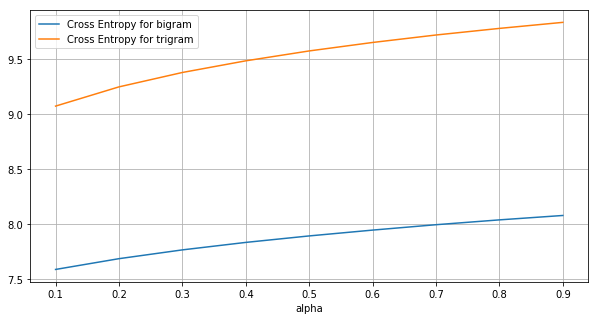

In [42]:
## plots##
# compare cross entropy between bigrams and trigrams for the values of alpha from 0.1 to 0.9
d={'alpha':d1['alpha'], 'Cross Entropy for bigram':d1['Cross Entropy'],'Cross Entropy for trigram':d3['Cross Entropy'] }
df = pd.DataFrame(data=d)
df["Cross Entropy for bigram"] = pd.to_numeric(df["Cross Entropy for bigram"])
df['Cross Entropy for trigram'] = pd.to_numeric(df['Cross Entropy for trigram'])
df[-15:].plot(x='alpha', y=['Cross Entropy for bigram', 'Cross Entropy for trigram'], figsize=(10,5), grid=True)

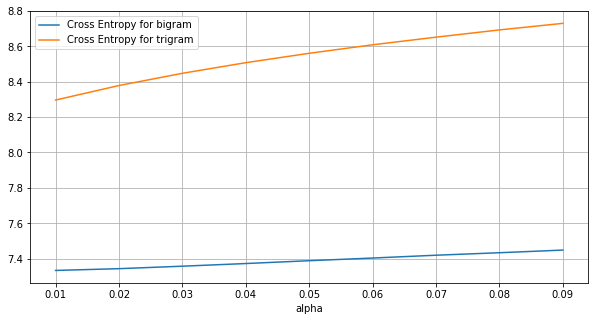

In [43]:
## plots##
# compare cross entropy between bigrams and trigrams for the values of alpha from 0.01 to 0.09
d={'alpha':d2['alpha'], 'Cross Entropy for bigram':d2['Cross Entropy'],'Cross Entropy for trigram':d4['Cross Entropy'] }
df = pd.DataFrame(data=d)
df["Cross Entropy for bigram"] = pd.to_numeric(df["Cross Entropy for bigram"])
df['Cross Entropy for trigram'] = pd.to_numeric(df['Cross Entropy for trigram'])
df[-15:].plot(x='alpha', y=['Cross Entropy for bigram', 'Cross Entropy for trigram'], figsize=(10,5), grid=True)

In [44]:
## (ii) 
sent=test_tokenized[0]
l=len(sent) # length of the sentence
sent = ['*start*'] + ['*start*'] + sent + ['*end*'] + ['*end*']
word=[]
big=[]
trig=[]
for idx in range(2,len(sent)):
    bi = round(math.log2(bigram_prob(sent[idx-1], sent[idx],0.01)), 3)
    tri = round(math.log2(trigram_prob(sent[idx-2],sent[idx-1], sent[idx],0.01)),3)
    word.append(sent[idx])
    big.append(bi)
    trig.append(tri)

In [45]:
import numpy as np
sbt = pd.DataFrame(np.column_stack([word, big, trig]), 
                               columns=['Words', 'Bigram', 'Trigram'])

sbt["Bigram"] = pd.to_numeric(sbt["Bigram"])
sbt["Trigram"] = pd.to_numeric(sbt["Trigram"])
def highlight_max(s):
    '''
    highlight the maximum in a Series 
    '''
    is_max = s == s.max()
    return ['background-color: darkorange' if v else '' for v in is_max]
sbt.style.apply(highlight_max, subset=['Bigram', 'Trigram'])

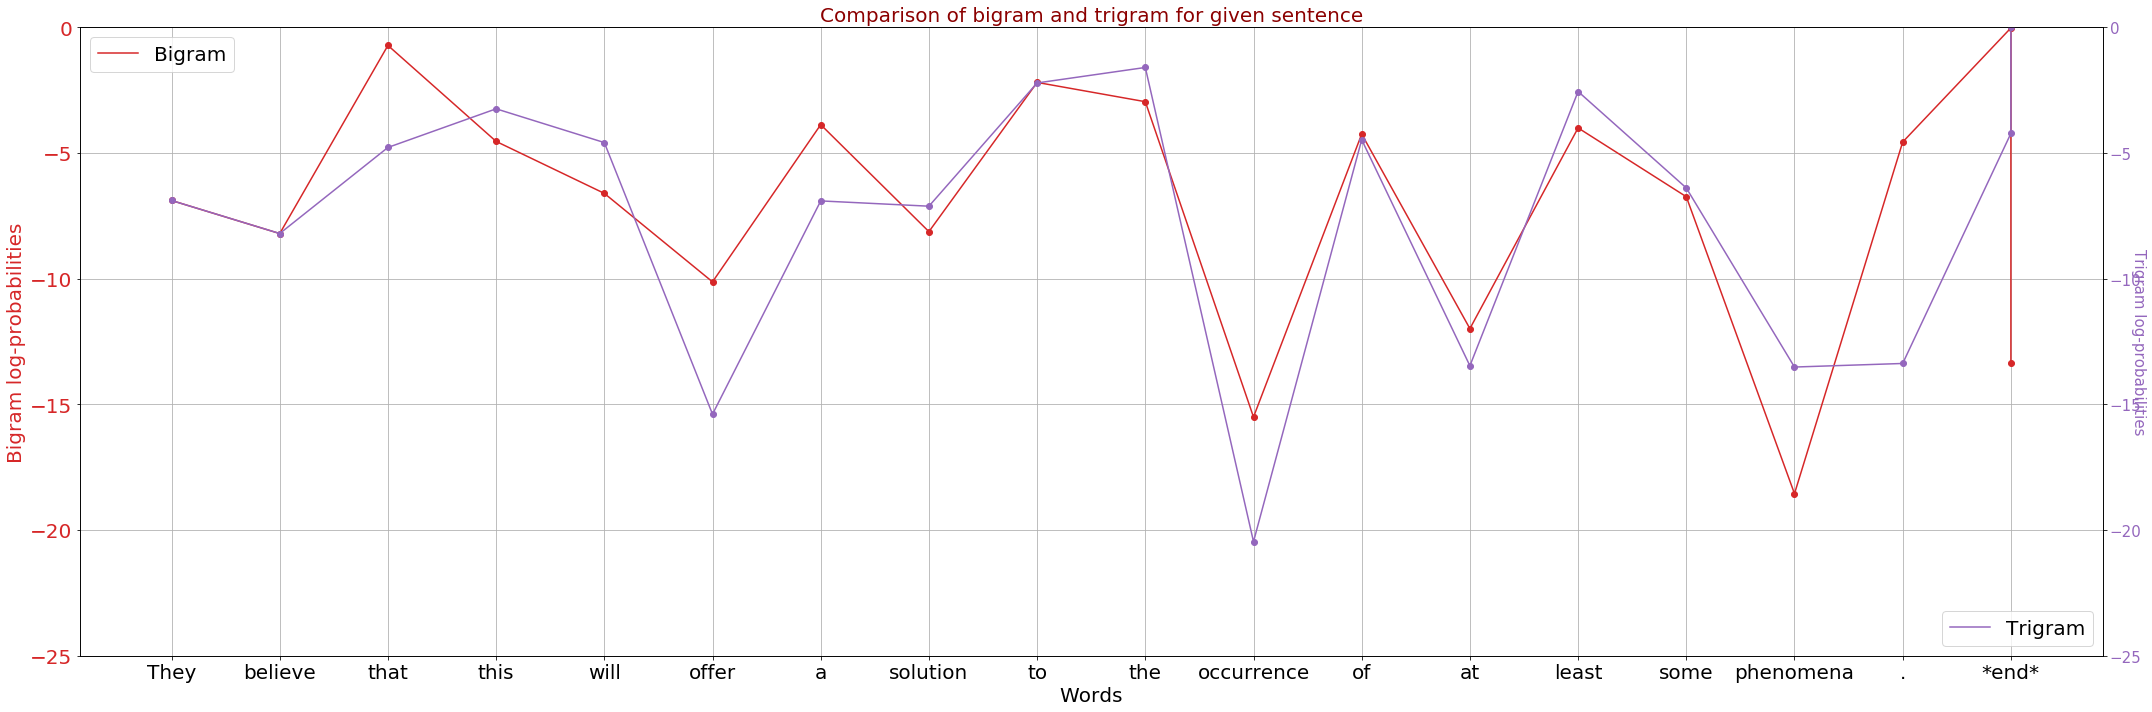

In [54]:
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.patches as mpatches


fig, ax1 = plt.subplots(figsize=(30,10))


color = 'tab:red'
ax1.set_xlabel('Words',fontsize=20)
ax1.set_ylabel('Bigram log-probabilities', color=color,fontsize=20)
ax1.plot(sbt['Words'],sbt['Bigram'] , color=color,label="Bigram")
ax1.set_ylim(-25,0)
ax1.tick_params(axis='y', labelcolor=color,labelsize=40)
plt.legend(loc=2, ncol=1,prop={'size': 20})
ax1.plot(sbt['Words'],sbt['Bigram'], 'o',color=color)


ax2 = ax1.twinx()  

color = 'tab:purple'
ax2.set_ylabel('Trigram log-probabilities', color=color,fontsize=15,rotation=270)  
ax2.plot(sbt['Words'], sbt['Trigram'], color=color,label="Trigram")
ax2.set_ylim(-25,0)
ax2.tick_params(axis='y', labelcolor=color,labelsize=15)
plt.legend(loc=4, ncol=1,prop={'size': 20})
ax2.plot(sbt['Words'],sbt['Trigram'], 'o',color=color)
plt.title('Comparison of bigram and trigram for given sentence',loc='center',
          color='darkred',fontsize=20)
ax1.grid(None)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 20)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [48]:
import random
random_sequence=random.choices(list(Voc),k=l)

In [49]:
sent=random_sequence
sent = ['*start*'] + ['*start*'] + sent + ['*end*'] + ['*end*']
word=[]
big=[]
trig=[]
for idx in range(2,len(sent)):
    bi=  round(math.log2(bigram_prob(sent[idx-1], sent[idx],0.01)), 3)
    tri =round(math.log2(trigram_prob(sent[idx-2],sent[idx-1], sent[idx],0.01)),3)
    word.append(sent[idx])
    big.append(bi)
    trig.append(tri)

random = pd.DataFrame(np.column_stack([word, big, trig]), 
                               columns=['Words', 'Bigram', 'Trigram'])
random["Bigram"] = pd.to_numeric(random["Bigram"])
random["Trigram"] = pd.to_numeric(random["Trigram"])
random.style.apply(highlight_max, subset=['Bigram', 'Trigram'])

In [56]:
round(math.log2(1/vocab_size), 3)

-13.37

In [58]:
## (iii) 

'''
Compute test-corpus cross_entropy 
& perplexity for bigram LM 
'''

sum_prob = 0
bigram_cnt = 0
alpha=0.01
for sent in test_sentences_tokenized:
    sent = ['*start*'] + sent + ['*end*']
    for idx in range(1,len(sent)):
        sum_prob += math.log2(bigram_prob(sent[idx-1],sent[idx],alpha))
        bigram_cnt+=1

HC = -sum_prob / bigram_cnt
perpl = math.pow(2,HC)
print('bigram model')
print('alpha=',alpha)
print("Cross Entropy: {0:.3f}".format(HC))
print("perplexity: {0:.3f}".format(perpl))
print('____________')

bigram model
alpha= 0.01
Cross Entropy: 7.409
perplexity: 169.923
____________


In [51]:
'''
Compute test-corpus cross_entropy 
& perplexity for tri-gram LM 
'''
alpha=0.01
sum_prob = 0
trigram_cnt = 0
for sent in test_sentences_tokenized:
    sent = ['*start*'] + ['*start*'] + sent + ['*end*'] + ['*end*']
    for idx in range(2,len(sent)):
        sum_prob += math.log2(trigram_prob(sent[idx-2],sent[idx-1], sent[idx],alpha))
        trigram_cnt+=1

HC = -sum_prob / trigram_cnt
perpl = math.pow(2,HC)
print('trigram model')
print('alpha=',alpha)
print("Cross Entropy: {0:.3f}".format(HC))
print("perplexity: {0:.3f}".format(perpl))

trigram model
alpha= 0.01
Cross Entropy: 8.406
perplexity: 339.291


In [52]:
## (iv)
###########Cross Entropy & Perplexity for interpoladed bi-gram & tri-gram LMs(lambda in (0.01,0.5,0.05))#########
sum_prob = 0
ngram_cnt = 0
d4=[]
alpha=0.01
for lamda in np.arange(0.01,0.5,0.05):
    for sent in develop_sentences_tokenized:
        sent = ['*start*']+ ['*start*'] + sent + ['*end*'] + ['*end*']
        for idx in range(2,len(sent)):
            sum_prob += (lamda * math.log2(trigram_prob(sent[idx-2],sent[idx-1], sent[idx],alpha))) +((1-lamda) * math.log2(bigram_prob(sent[idx-1], sent[idx],alpha)))
            ngram_cnt+=1 

    HC = -sum_prob / ngram_cnt
    perpl = math.pow(2,HC)

    d4.append({'Cross Entropy': format(round(HC,3)), 'lambda': lamda, 'Perplexity': format(round(perpl,3))})

d4=pd.DataFrame(d4)
columnsTitles=['lambda','Cross Entropy','Perplexity']
d4=d4.reindex(columns=columnsTitles)
d4

lambda Cross Entropy Perplexity
0    0.01         7.544    186.577
1    0.06         7.563    189.052
2    0.11         7.582    191.559
3    0.16         7.601      194.1
4    0.21          7.62    196.675
5    0.26         7.639    199.284
6    0.31         7.658    201.927
7    0.36         7.677    204.606
8    0.41         7.696     207.32
9    0.46         7.715     210.07

In [53]:
'''
Compute corpus cross_entropy 
& perplexity for interpolated bi-gram
& tri-gram LMs 
'''

alpha= 0.01
lamda = 0.01
sum_prob = 0
ngram_cnt = 0
for sent in test_sentences_tokenized:
    sent = ['*start*'] + ['*start*'] + sent + ['*end*'] + ['*end*']
    for idx in range(2,len(sent)):
        sum_prob += (lamda * math.log2(trigram_prob(sent[idx-2],sent[idx-1], sent[idx],alpha))) +((1-lamda) * math.log2(bigram_prob(sent[idx-1], sent[idx],alpha)))
        ngram_cnt+=1 

HC = -sum_prob / ngram_cnt
perpl = math.pow(2,HC)
print('interpolation model')
print('alpha=',alpha)
print('lamda=',lamda)
print("Cross Entropy: {0:.3f}".format(HC))
print("perplexity: {0:.3f}".format(perpl))

interpolation model
alpha= 0.01
lamda= 0.01
Cross Entropy: 7.625
perplexity: 197.392
